<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S43_logistics_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.display import show
from gtbook import logistics

N = 5
indices = range(1, N+1)
u = {k:gtsam.symbol('u',k) for k in indices[:-1]} # controls u_k
x = {k:gtsam.symbol('x',k) for k in indices}      # states x_k
z = {k:gtsam.symbol('z',k) for k in indices}      # measurements z_k

# Sensor Models with Continuous State

> From Gaussian to non-Gaussian sensors.

<img src="Figures4/S43-Warehouse_robots-08.jpg" alt="Splash image with warehouse robot surrounded by sensor-like implements" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

In the previous chapters, we have used sensors that could be characterized using fairly simple probabilistic
models, either discrete conditional probability distributions (e.g., conductivity for the trash-sorting robot
and light sensing for the vacuum cleaning robot), or one-dimensional Gaussian distributions (as for the trash-sorting robot's weight sensor).  In this section we introduce three more realistic sensors,
each of which are similar to sensors that are frequently used in modern robotic systems:
- a proximity sensor
- an RFID range sensor, which has a non-linear measurement prediction model
- a GPS-like location sensor, which uses a linear-Gaussian conditional density

The proximity sensor detects when the robot is near an obstacle. Therefore, this sensor's
response depends on the geometry of the environment.
Let us extend the example from the last section, a warehouse of 100m x 50m, by adding four sets of shelves
placed at regular intervals
A base map for this environment is defined in `gtbook.logistics`. Below we plot this `base_map` as an image:

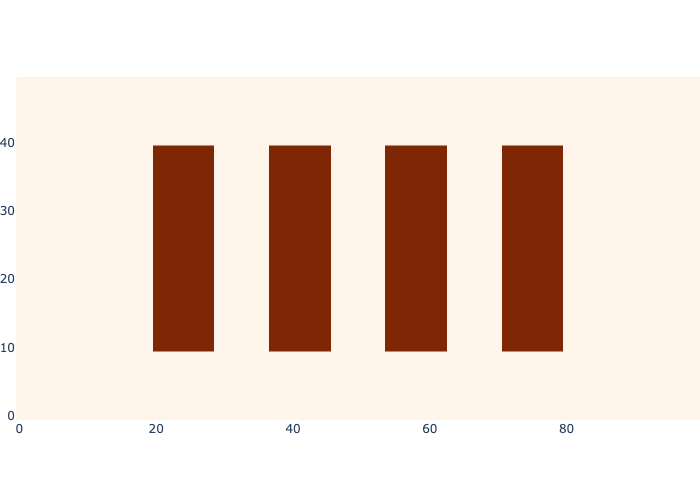

In [4]:
logistics.show_map(logistics.base_map)

## A proximity sensor

> A binary sensor over a continuous space.

We consider a sensor that measures the *proximity* of the robot to obstacles. For example, this could be operationalized using small infrared sensor/receiver pairs, or a magnetic sensor that measures proximity to one of the metal structures within the warehouse.

This is a *binary* sensor, just like the conductivity sensor we saw in the trash sorting example. However, a big difference is that the measurement $z_k$ of this sensor at time $k$ depends on the *continuous* state $x_k$. 
In other words, this is a kind of *hybrid*, discrete-continuous sensor model.

This sensor can be modeled using a **signed distance function** (SDF), which is a well-known concept from graphics.
An SDF measures the distance from any point $x$ to the nearest obstacle, is positive if this location is outside the obstacle, and negative if it is inside the obstacle. Robots will never see negative SDF values.
Let $X_{obs}$ denote the set of points on the boundary of the obstacles (the borders of the shelves, and the
walls that enclose the warehouse).
For a given point $x \in {\cal D}$, the distance to the nearest obstacle can be defined by

$$
d(x) = \min_{y \in X_{obs}} \|x - y\|^{1/2}
$$

We now define the signed distance to be negative for $x$ is inside the obstacle, and positive for points outside the obstacle:

$$
\mathop{sdf}(x)
= 
\left\{
    \begin{array}{lcr} - d(x) & & x \mathop{\; inside\; obstacle}\\
    + d(x) & & x \mathop{\; outside\;  obstacle}\\
\end{array}
\right.
$$

We can use the function *sdf* to model our proximity sensor by defining a conditional probability
distribution $P(z_k=\text{ON}|x_k)$ as a function of $\mathrm{sdf}(x)$.
For example, if obstacle detection is very reliable for for $d(x) < d_0$,
but degrades rapidly as $d(x)$ increases (i.e., as the robot moves further from obstacles),
we might define

$$
P(z_k=\text{ON}|x_k) = 
\left\{
    \begin{array}{lcr} 1 & & d(x) < d_0 \\
     e^{- \alpha d(x)} && \mathrm{otherwise}\\
\end{array}
\right.
$$

where the value of $\alpha > 0$ determines how rapidly the probability decreases.
Because the conditional probability $P(\cdot | x_k)$ is a valid probability distribution,
we can immediately conclude that
$P(z_k=\text{OFF}|x_k) = 1 - P(z_k=\text{ON}|x_k)$.

Below, we use a simpler model, which assumes that the proximity sensor perfectly
detects when the robot is within distance $d_0$ of an obstacle:

$$
P(z_k=\text{ON}|x_k)
= 
\left\{
    \begin{array}{lcr} 1 & & d(x) < d_0 \\
     0 && \mathrm{otherwise}\\
\end{array}
\right.
$$

Below we show the ON and OFF *likelihood* images for this simple model. Recall that the likelihood $l(x_k;z_k=\text{ON})\propto P(z_k=\text{ON}|z_k)$ is a function *of the state* $x_k$, so we can show it as a map:

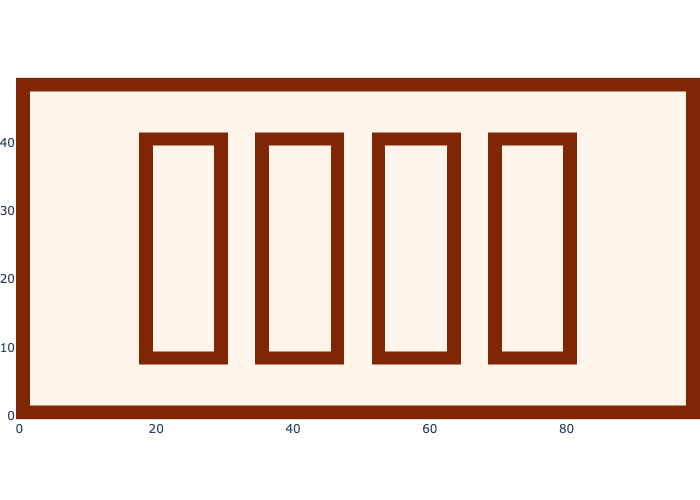

In [5]:
logistics.show_map(logistics.proximity_map_on)

Note that we denote a likelihood over a continuous variable with lowercase $l()$, in analogy to the lowercase $p()$ we use for densities. For this specific sensor model, at any location, the likelihood $l(x_k;z_k=\text{OFF})$ of $x_k$ given that the sensor is OFF will be the mirror image of the map above:

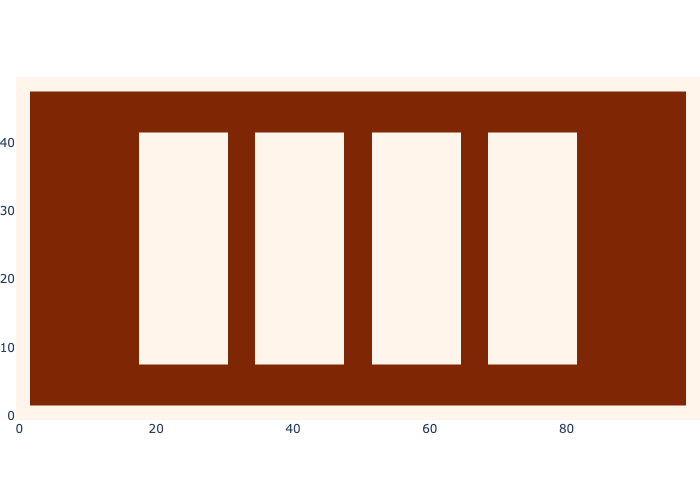

In [6]:
logistics.show_map(logistics.proximity_map_off)

## A Range Sensor

> A range sensor is *non-linear*.

Let us assume that the operator of the warehouse has installed a number of *beacons* throughout the warehouse, at strategically placed locations. The measurement function $h(x_k; b_i)$ for a sensor measuring the range to a beacon at location $b_i$ is non-linear:

$$
h(x_k;b_i) = \|x_k - b_i\| = \sqrt{(x_k - b_i)^T(x_k - b_i)}
$$

The energy emitted by an RFID beacon is, of course, finite. Therefore, there is some maximal
distance, say $d_{\max}$, beyond which the sensor is unable to detect the beacon.
In this case, the sensor does not return any range measurement, and indicates
"no beacon present."


This is actually not an unrealistic model;
there is a technology called [radio frequency identification (RFID)](https://en.wikipedia.org/wiki/Radio-frequency_identification), which can be detected using a small radio receiver, and some of the more expensive variants allow for the range to the RFID to be measured, if not very accurately.

As with the motion model described above, it is typical to assume additive Gaussian
noise for sensors, leading to the measurement model:

$$z_k = h(x_k;b_i) + w_k$$

in which $w_k$ is the noise term (unrelated to the noise in our motion model).
Using this model, we see that the the conditional probability of a range measurement $z_k$ given a continuous state $x_k$ *is* a Gaussian, even though its mean $\mu$ is computed as a nonlinear function of the $x_k$.

$$
\begin{aligned}
p(z_k|x_k; b_i) &= \mathcal{N}(z_k;\mu=h(x_k;b_i), \sigma^2) \\
&= \frac{1}{\sqrt{2\pi\sigma^2}} \exp\{-\frac{1}{2\sigma^2}(z_k-h(x_k;b_i))^2\}
\end{aligned}
$$

Note that the range is one-dimensional, so we again use the simpler univariate Gaussian notation, and we use the variance $\sigma^2$ to characterize the zero-mean Gaussian noise.

The equation below for the *likelihood* of the state $x_k$ given a measurement $z_k$ (to beacon $b_i$) seems similar to a Gaussian density:

$$
L(x_k;z_k, b_i) = \exp\{-\frac{1}{2\sigma^2}(z_k-h(x_k;b_i))^2\}.
$$

However, because the likelihood is a function of $x_k$, and not a function of $z_k$ (remember, $z_k$ is *given*
when we compute the likelihood for state $x_k$),
the likelihood does not even remotely look like a Gaussian! 
In fact, the likelihood will be high where the state agrees with the given range measurement, i.e., in an *annulus* of the right radius around the beacon. The "width" of the annulus will be proportional to the measurement noise $\sigma$.

To make this concrete, let us add 8 beacons to the base map, at either side of the shelves, which seems very useful for robot navigation. Again, we defined these in `gtbook.logistics.beacons`, and we show them below on the base map:

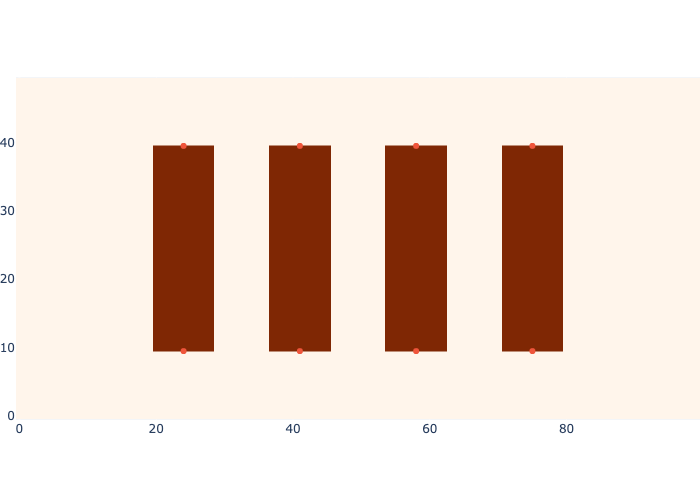

In [7]:
logistics.show_map(logistics.base_map, logistics.beacons)

We can implement a range function that works with any beacon:

In [8]:
def rfid_range(position, beacon, max_range=8):
    """return range to given beacon"""
    range = np.linalg.norm(position-beacon)
    return float('inf') if range>max_range else range

For example, if the robot is at $(20.5, 7.5)$, we are within range of beacon $0$:

In [9]:
state = gtsam.Point2(20.5, 7.5)
beacon0 = logistics.beacons[0]
zk = rfid_range(state, beacon0)
print(f"range to beacon 0 = {zk}")

range to beacon 0 = 4.031128874149275


Now we are in a position to show the annulus-like likelihood images:

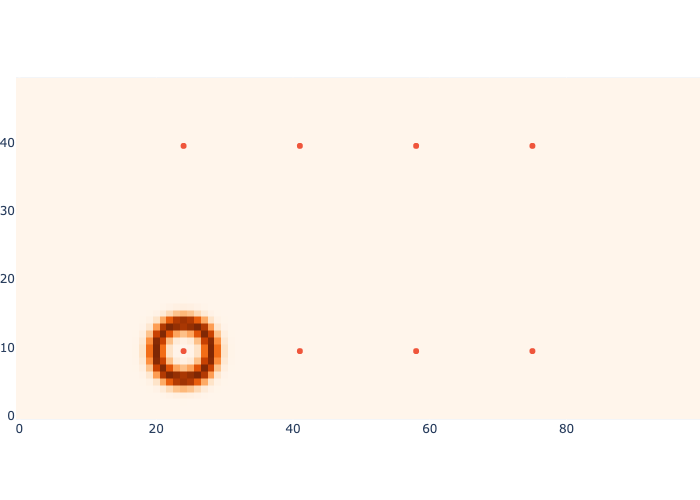

In [10]:
dist = np.array([[rfid_range(xy, beacon0) for xy in row] for row in logistics.map_coords])
sigma = 1  # In meters
likelihood = np.exp(-1/(2 * sigma**2) * (zk - dist)**2)
logistics.show_map(likelihood, logistics.beacons)

As you can see, *all* positions at a range of approximately 4 meters have a high likelihood. 

## Negative Information

> Negative information is also information!

The likelihood model above is useful when a beacon is within sensing range of the RFID reader. But what happens when all beacons are out of range? Let us assume that the RFID reader always returns the range to the closest beacon, along with its identification number, but it returns a special value when all the beacons are out of range. Formally, we can model this as a *pair* of values that is returned by the sensor,

$$z_{RFID}\in \bar{N} \times \mathbb{\bar{R}}^+,$$

where $\bar{N}$ is the set of integers extended with `None`, and $\mathbb{\bar{R}}^+$ is the set of positive real numbers extended with $\infty$.

In code this easy to implement: if all sensors are out of range we  return `None` for the identification and `float('inf')` for the range. For example, here is some code that returns the range to the nearest beacon (given in a list `beacons`) and `None, float('inf')` if all are out of range:

In [11]:
def rfid_measurement(position, max_range=8):
    """Simulate RFID reader that returns nearest RFID range or (None,inf)."""
    ranges = [rfid_range(position, beacon, max_range) for beacon in logistics.beacons]
    range = min(ranges)
    return (np.argmin(ranges), range) if range<=max_range else (None,range)

print(rfid_measurement(gtsam.Point2(20,7)))
print(rfid_measurement(gtsam.Point2(7,7)))

(0, 4.716990566028302)
(None, inf)


The special "out of range" measurement conveys a lot of information as well! If we are within range of a sensor, the likelihood function is as above (an annulus). But when we are *out* of range, the likelihood function has a very strange shape indeed: it will be 1.0 for all continuous states out of range of all beacons, and zero for states within range of a beacon. This makes sense: if the robot were within range of a beacon, the sensor would have returned
an actual range, *not* infinity. This in turn tells us that the robot must be somewhere outside the range of all beacons, which is very powerful information.

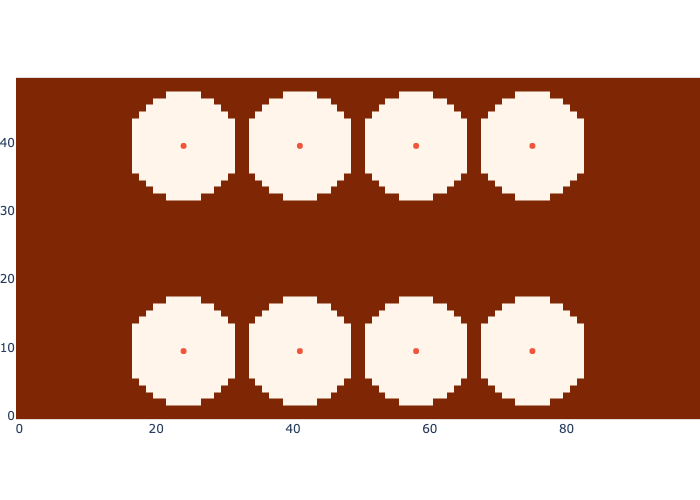

In [12]:
def out_of_rfid_range(position, max_range=8):
    id, _ = rfid_measurement(position, max_range)
    return id == None

out_of_bound_map = np.array([[out_of_rfid_range(xy) for xy in row] for row in logistics.map_coords])
logistics.show_map(out_of_bound_map, logistics.beacons)


## A GPS-Like Location Sensor

> A simple conditionally Gaussian measurement.

The last sensor we will consider, a GPS-like location sensor, is a bit of a cheat. In fact, there are no great indoor GPS-like sensors.
People have tried all kinds of things, like triangulating WiFi signals etc., but in fact a cheap and reliable GPS-like sensor that works indoors is still not available at the time of writing. 
However, it is a good illustrative example to introduce a simple, conditionally Gaussian measurement. 
Also, it can be a good way to model a more complicated sensor, e.g., a camera-based localization system that uses some type of map.

The **measurement model** $h(x_k)$, that predicts the measurement $z_k$ given the state $x_k$, will again be a conditional Gaussian. In this example, let us assume the measurement is simply the location of the robot, but with coordinates measured in *cm*. The measurement model in this case is *linear*, and we again assume additive noise:

$$
{z}_k = h(x_k) + w_k = C x_k + w_k
$$

The matrix $C$ performs a linear transformation on the state, such as converting
between different units.
Suppose for example that the state is defined in meters and the sensor measures in
centimeters.
In this case, we could use the $2\times2$ diagonal matrix $C=\text{diag}(100,100)$ to
apply the appropriate scaling factor to convert from meters to centimeters. 
Under the assumption that $w_k$ is again zero-mean, Gaussian noise, the conditional density $p(z_k|x_k)$ of the measurement $z_k$ given the state $x_k$ is then

$$
\begin{aligned}
p(z_k|x_k) &= \mathcal{N}(z_k;\mu=C x_k, \Sigma=R) \\
&= \frac{1}{\sqrt{2\pi  |R|}} \exp\{-0.5 (z_k-C x_k)^TR^{-1}(z_k-C x_k)\}
\end{aligned}
$$

where $R$ is the traditional symbol used for measurement model covariance,
and $|R|$ in the denominator denotes the determinant of $R$. Assuming a fairly inaccurate sensor, with 30cm standard deviation, we have $R=\text{diag}(30^2,30^2)$. Note that the $2\times 2$ measurement covariance matrix $R$ is expressed in the units of the measurement, i.e., centimeters, *not* the units of the state.

## Simulating States *and* Measurements

> Dynamic Bayes nets to the rescue, again!

We can now extend the Gaussian DBN from the previous section to include  measurements, so that we can
encode the joint density $p(X,Z|U)$ on states $X$ *and* measurements $Z$, given the controls $U$:

$$
p(X,Z|U) = p(x_1)p(z_1|x_1) \prod_{k=2}^N p(x_k|x_{k-1}, u_{k-1})p(z_k|x_k).
$$

Let us add the measurement conditionals to the DBN from the previous section to get an extended dynamic Bayes net:

In [13]:
gaussianBayesNet = gtsam.GaussianBayesNet()
A, B, C = np.eye(2), np.eye(2), 100 * np.eye(2)
motion_model_sigma = 0.2
measurement_model_sigma = 30
for k in indices:
    gaussianBayesNet.push_back(gtsam.GaussianConditional.FromMeanAndStddev(
        z[k], C, x[k], [0, 0], measurement_model_sigma))
for k in reversed(indices[:-1]):
    gaussianBayesNet.push_back(gtsam.GaussianConditional.FromMeanAndStddev(
        x[k+1], A, x[k], B, u[k], [0, 0], motion_model_sigma))
p_x1 = gtsam.GaussianDensity.FromMeanAndStddev(x[1], [20,10], 0.5)
gaussianBayesNet.push_back(p_x1)

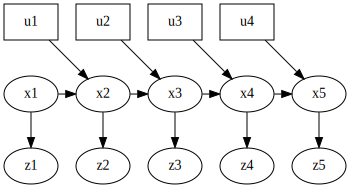

In [14]:
position_hints = {'u': 2, 'x': 1, 'z': 0}
show(gaussianBayesNet, hints=position_hints, boxes=set(list(u.values())))

This now allows us to simulate a trajectory and *simultaneously* simulate a set of measurements:

In [15]:
control_tape = gtsam.VectorValues()
for k, (ux,uy) in zip(indices[:-1], [(2,0), (2,0), (0,2), (0,2)]):
    control_tape.insert(u[k], gtsam.Point2(ux,uy)) 

In [16]:
gaussianBayesNet.sample(control_tape)

Variable,value
u1,2 0
u2,2 0
u3,0 2
u4,0 2
x1,20.6469 10.199
x2,22.8706 9.90054
x3,24.8089 10.1832
x4,25.1275 12.2733
x5,25.0941 14.5563
z1,2117.85 1015.76


## GPS-style Likelihoods

> A likelihood is not a probability. A likelihood is not a probability. A likelihood is not a probability.

Let us recall the definition of a likelihood of a state $x$ from section 2.4, as being a function *proportional* to the conditional density of a measurement $z$, but viewed as a function of $x$:

$$L(x;z) \propto p(z|x).$$

The notation emphasizes that the measurement $z$ is given, and the likelihood is a function defined on the state *continuous* state $x$.

What is the likelihood function for our GPS-like sensor? That's easy enough: we take the conditional probability, drop the normalization constant, and view it as a function of the state $x_k$ rather than the *known* measurement $z_k$:

$$
L(x_k;z_k) \doteq \exp\{-0.5 (z_k-C x_k)^TR^{-1}(z_k-C x_k)\}
$$

It turns out that in this case (when $C$ is a square, nonsingular matrix,
and $x_k, z_k \in \mathbb{R}^n$), the likelihood function *looks* just like a Gaussian, because we can re-write the above as

$$
\begin{aligned}
L(x_k;z_k) \doteq \exp\{-0.5 (x_k-C^{-1}z_k)C^T R^{-1}C(x_k-C^{-1}z_k)\}
\end{aligned}
$$

which is *proportional* to a Gaussian density with mean $C^{-1}z_k$ and covariance matrix $\Sigma=(C^T R^{-1}C)^{-1}=C^{-1}RC^{-T}$. This actually makes sense: the most *likely* state $x_k$ given a measurement $z_k$ is just the measurement, now *divided* by 100 to convert to meters, hence the $C^{-1}$. The covariance is scaled down by 10,000. However, it is important not to go too far and start interpreting this Gaussian-shaped function as a probability: it does not normalize to 1, and it is a coincidence that for *linear-conditional* Gaussians, the likelihood turns out to be Gaussian-shaped as well.

## GTbook 101

> About code defined in gtbook library.

Again we used some code defined in the `gtbook` library:
- `logistics.base_map`: a 50x100 image with the warehouse shelves
- `logistics.beacons`: an 8x2 array of beacon locations